# Day 2, Session 1, MD workshop
### Dr. Michael Shirts, CU Boulder

In [ ]:
# Only if you are on Google Colab, run this and the next two cells
# This will crash your kernel- this is OK and expected! Run this just once,
# then the next two cells 
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
import condacolab
condacolab.check()

In [ ]:
!mamba install -c conda-forge "hoomd=4.7.0" vim openssh mbuild gsd ipython ipykernel mdanalysis foyer freud ipywidgets scipy numpy physical_validation matplotlib jupyter pandas flowermd nglview mdanalysis

## How do we understand the information we get out of simulations?

In [2]:
# load up some modules.

import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import pandas as pd
%matplotlib inline

Let's load up some typical data from a simulation:

In [3]:
potential = np.loadtxt('potential.dat')
# in google collab: see document for the location, or 
# just put in the raw location of this file (it's in the same directory as this notebook)

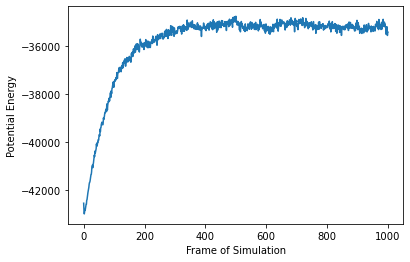

In [4]:
plt.plot(potential)
plt.xlabel("Frame of Simulation")
plt.ylabel("Potential Energy")
plt.show()


**Question: What should I report as the average potential energy of this simulation?**

**Possible Answers**:

In [5]:
np.mean(potential)  # not good, because it includes data from before equilibration

-35841.17738512487

In [6]:
np.mean(potential[500:]) # better, because we are eliminating the pre-equilibration time

-35179.34066243115

What is the uncertainty in this average? i.e. the standard error of  the mean? Does this seem reasonable?

**Answer** The standard error of the mean would be reasonable if the samples are independent, 
but they are not; they are somewhat similar to the points right before them.  We need to come up with ways to handle that.


In [ ]:
np.std(potential[500:])/np.sqrt(500)

#### Reporting statistics for non-normal distributions

Let's tale a look at a distribution that is **not** Gaussian

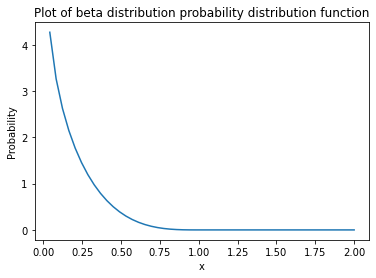

In [11]:
betaf = scipy.stats.beta(0.8,4)
x = np.linspace(0,2)
plt.plot(x,betaf.pdf(x))
plt.title('Plot of beta distribution probability distribution function')
plt.ylabel('Probability')
plt.xlabel('x')
plt.show()

Now, collect 10,000 samples from this distribution

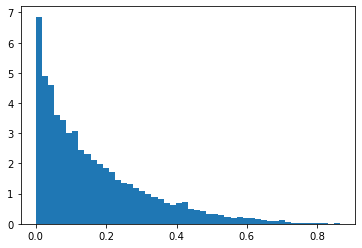

In [12]:
num = 10000
samples = betaf.rvs(num)
plt.hist(samples,bins=50,density=True)
plt.show()

### Pause and do some calculations

* What would you report as the mean and standard deviation of an observation from this distribution?
* What might be a better way to report the behavior of this distribution?

**Potential Answers:**

In [13]:
mean = np.mean(samples)
print(f"mean = {mean:.4f}")

mean = 0.1650


In [14]:
std = np.std(samples)
print(f"std = {std:.4f}")

std = 0.1537


In [15]:
# what is the 95% confidence interval of an obserbation this distribution using the formula?
print(mean - 2*std)
print(mean + 2*std)

-0.1424331705857554
0.4724990336027521


Clearly, the mean and standard deviation are not a good way to describe the distribution of individual samples from this distribution!

In [18]:
# better description
xlow = np.percentile(samples,2.5)
xhigh = np.percentile(samples,97.5)
print(f" 2.5% percentile is : {xlow:.4f}")
print(f"97.5% percentile is : {xhigh:.4f}")
print(f"95% percentile range is ({xlow:.4f},{xhigh:.4f})")

 2.5% percentile is : 0.0024
97.5% percentile is : 0.5688
95% percentile range is (0.0024,0.5688)


Direct calculations of the percentiles of the distribution are better ways to describe nonnormal distributions. 

### What about the error in the *mean* of this distribution?

We can look at the distributions of averages of $N$ samples at a time.

In [22]:
def distribution_of_means(num,nrepeats):
    repeats = np.zeros(nrepeats)  # number of times we take the mean.
    for i in range(nrepeats):
        repeats[i] = np.mean(betaf.rvs(num))  # average num samples together
    return repeats

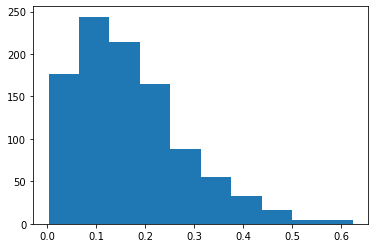

In [21]:
plt.hist(distribution_of_means(2,1000))
plt.show()

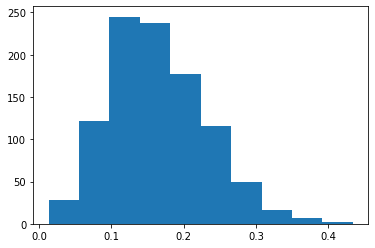

In [23]:
plt.hist(distribution_of_means(5,1000))
plt.show()

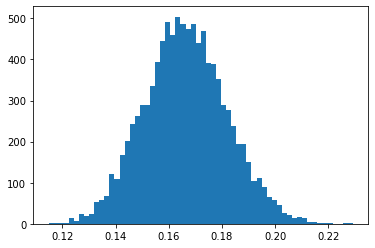

In [24]:
plt.hist(distribution_of_means(100,10000),bins=60)
plt.show()

In [25]:
# the formula for standard deviation of error now works!
# the distribution of MEANS is well described 
print(mean - 2*std/np.sqrt(100))
print(mean + 2*std/np.sqrt(100))

0.13428632129907297
0.19577954171792372


## Determining independent points: the autocorrelation time

Important: all of this below is only valid for a _stationary_ timeseries, that are no longer equilibrating.

Pandas implements an autocorrelation function as a function of _lag_ ($\tau$)

In [26]:
start = 500
panda_pot = pd.Series(potential[start:]-np.mean(potential[start:]))
panda_pot.autocorr(3)

0.35636797425369793

### Programming Exercises

 * Use the `autocorr` function to calculate the entire autocorrelation function for all $\tau$.  
 * Bonus points: Compute the autocorrelation function from scratch and compare.
 * Can you use your estimate of the autocorrelation function to find the the lag time $\tau$ at which the system becomes uncorrelated (i.e. the autocorrelation function) to show points spaced more than $\tau$ are independent? 
 * **Note:** We also assume that the distribution is stationary, so we need to just do this analysis after equilibration has occurred.
 * **Also Note:** the formulas assume that the average if the timeseries is zero, so you should subtract off the average first.
 

**Answers:**

In [27]:
start = 500
stationary = pd.Series(potential[start:])-np.mean(potential[start:])
n_autocorr = np.shape(stationary-1)[0]
nlim = int(n_autocorr/4)
acf = np.zeros(nlim)
for i in range(nlim):
    acf[i] = stationary.autocorr(i)

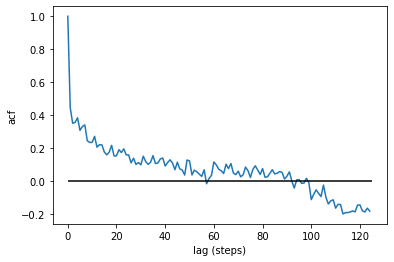

In [28]:
np.arange(nlim)
plt.plot(np.arange(nlim),acf)
plt.hlines(0,0,nlim,'k')
plt.xlabel("lag (steps)")
plt.ylabel("acf")
plt.show()

### When does the ACF become essentially zero?

What's your guess looking at the ACF?

### Fitting ACF to an exponential to estimate correlation time.

In [29]:
from scipy.optimize import curve_fit

In [30]:
def exponential(x, r): #function f(x, r) = e^(r*x)
    #return np.e ** (r * x)
    return np.exp(r*x) 

In [32]:
#This function calculates tau by using an exponential fit.
#To do this it uses scipy.optimize curve_fit
#curve_fit will optimize any function to fit given data

def tau_calc(ac_data, function = exponential): #takes in data and a python function
    x_data = np.arange(len(ac_data))
    pars, cov = curve_fit(f=function, xdata=x_data, ydata=ac_data, p0=[0], bounds=(-np.inf, np.inf))
    #curve fit returns an np.array of optimally fit paramters(pars) and their coverience(cov)
    #pars in this case will return an optimized value of k to fit the dataset
    return -1/pars #tau = -1/k
# scipy curve_fit documentation: https://towardsdatascience.com/basic-curve-fitting-of-scientific-data-with-python-9592244a2509

In [33]:
tau = tau_calc(acf)[0]
print(tau)

6.267894533721248


This $\tau$ is the time it takes to go from 1 to $1/e$. So we actually can show we want to go out $2\tau$ for the samples to be totally decorrelated (there's some theory that this far enough, even though it's not quite zero)

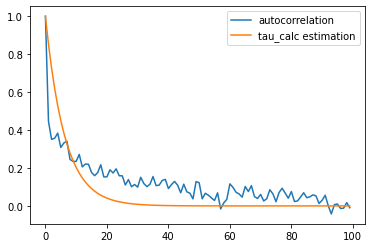

In [35]:
x_data = np.arange(100)
plt.plot(x_data,acf[0:100], label='autocorrelation') 
plt.plot(exponential(x_data, -1/tau), label = 'tau_calc estimation')
plt.legend()
plt.show()

*Key point*: If the data fits an exponential well, we can treat it as uncorrelated samples if they samples are $2\tau$ apart. 

In [36]:
start = 500
mean = np.mean(potential[start:])
print(mean)

-35179.34066243115


In [ ]:
nsamples = (len(potential)-start)/(2*tau)
print("Nsamples =", nsamples)

We should use this instead of `nsamples` above.

In [40]:
stderr_mean = np.std(potential[start:])/np.sqrt(nsamples)

In [41]:
print(f"Mean = {mean}, sderr_mean = {stderr_mean}")

Mean = -35179.34066243115, sderr_mean = 21.157772133139186


### Calculating thermophysical observables

What we are probably interested in is the average potential energy per molecule, not the total potential energy. 

We can estimate the heat of vaporization $H_{vap}$ by:
    
\begin{eqnarray}
H_{vap} &=& H_{gas}-H_{liquid} \\
        &=& U_{gas} + PV_{gas} - (U_{liquid} + PV_{liquid}) \\ 
        &=& \left(U_{gas} - U_{liquid}\right) - P \left(V_{gas}-V_{liquid}\right) \\ 
\end{eqnarray}

Since the kinetic energy of liquid and vapor is the same, then this is

\begin{eqnarray}
U_{pot,gas} - U_{pot,liquid} + P(V_{gas}- V_{liquid})
\end{eqnarray}

If we assume ideality of gas ($PV=nRT$), and zero internal energy (which is valid for rigid water, like TIP3P or SPC/E), then we get:

\begin{eqnarray}
       &=& - U_{pot,liquid} + P\left( \frac{nRT}{P} - V_{liquid}\right) \\
        &=& - U_{pot,liquid} + nRT - PV_{liquid} \\
\mathrm{H_{Molar}} &=& -\frac{U_{pot,liquid}}{N} + RT - \frac{PV_{liquid}}{N}
\end{eqnarray}

The data set potential.dat we have been playing with was from a simulation of TIP3P water with 900 molecules.

We note that the $\frac{PV_{liquid}}{N}$ term is almost zero away from the critical point, so we actually can ignore it.

In [42]:
(0.101)*(18.02)/(900*1000)  # 18.02 g/mol x 1 L*cm^3 / 1000 g  x 1 atm x 0.101  kJ / L*atm

2.0222444444444443e-06

So we are left with: $\mathrm{H_{Molar}} = -\frac{U_{pot,liquid}}{N}+RT$, where $U_{pot,liquid}$ is the *average* potential energy of the liquid state $\langle U \rangle$ we have been calculating with above. 

### Exercises

What is the $H_{vap}$ of water at 300 K predicted by this simulation? What is the uncertainty in the estimate? How does it compare to the experimental $H_{vap}$ of water at 300 K, which is 40.7 kJ/mol?

**Answers:**

In [43]:
R = 0.008314 # in J/mol
N = 900 # number of waters
T = 300

In [44]:
print(f"Hvap = {-mean/N + R*T:.3f} +/- {stderr_mean/N:.3f} kJ/mol")

Hvap = 41.582 +/- 0.024 kJ/mol


These results properly use the stationary part of the data series (eliminating the equilibration time), and calculate the uncertainty with the proper number of uncorrelated samples.

## Automated tool for equilibration detection and correlation

We can use scipy statistical tests to see if two parts of the distributions are within the uncertainties of each other.  

**Note**: We have to use uncorrelated samples, or it will erroneously say that they are NOT within uncertainties of each other.

A higher T-statistic means more difference between the data sets.

A lower P-value indicates a low probability that the difference in means was by chance.

P-value < 0.05 suggest they are two different data sets! 

### Exercise:  Use this code to estimate better than "eyeballing" what fraction is equibrated  

In [45]:
start = 0
cut = 500
stop = 1000
per_ind_sample = 1  # the number of indices between independent samples
# compare 
scipy.stats.ttest_ind(potential[start:cut:per_ind_sample],potential[cut:stop:per_ind_sample],equal_var=True)


Ttest_indResult(statistic=-14.984452443412309, pvalue=6.184533203981602e-46)

Approximately what is the number of samples we should skip each time to have roughly independent data?

In [52]:
per_ind_sample = int(np.ceil(2*tau))
print(per_ind_sample)

13


In [53]:
start = 0
cut = 500
stop = 1000  # the number of indices between independent samples
# compare 
scipy.stats.ttest_ind(potential[start:cut:per_ind_sample],potential[cut:stop:per_ind_sample],equal_var=True)


Ttest_indResult(statistic=-4.2479005070606215, pvalue=6.051413075542527e-05)

Still definitely not independent!  At what point might they be independent?

**Possible Answers:** 

In [55]:
start = 400
cut = 700
stop = 1000
# compare 
scipy.stats.ttest_ind(potential[start:cut:per_ind_sample],potential[cut:stop:per_ind_sample],equal_var=True)

Ttest_indResult(statistic=1.3691432962154289, pvalue=0.17760279853397873)

Much closer to the two halves being the same distribution!  

There are some additional tools (`pymbar.timeseries` equilibration detection), for example that can automate this more.  Note: these tend to be quite aggressive in deciding how much simulation time to cut off!

In [60]:
from pymbar import timeseries

In [58]:
[t0, g, Nindep] = timeseries.detect_equilibration(potential)
# t0 is the initial point detected as starting the stationary point.
# g is the estimate of the correlation time (approximately 2tau)
# Neff_max is an estimate of the _effective_ number of samples.

In [61]:
print('Equilibration time =',t0)
print('Correlation time = ',g)
print('Number of independent samples =', Nindep)

Equilibration time = 745
Correlation time =  5.662475
Number of independent samples = 45.386513
